`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2021/2022`

Холькина А.А.
**ВАРИАНТ: 3, БУСТИНГ**

In [1]:
# настройка ширины страницы блокнота .......................................
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# расширение watermark для вывода информации о версиях пакетов
#  https://github.com/rasbt/watermark
# установка: командная строка - pip install watermark
# %load_ext watermark

# Лабораторная работа №5: Методы, основанные на деревьях решений. Регрессионные деревья. Деревья классификации. Случайный лес. Бустинг.  

В практических примерах ниже показано:   

* как делать перекодировку признаков в номинальной и порядковой шкалах
* как вырастить дерево и сделать обрезку его ветвей   
* как настроить модель бэггинга   
* как вырастить случайный лес  
* как настроить модель бустинга на деревьях решений  
* как подбирать настроечные параметры моделей методом сеточного поиска  

Точность всех моделей оценивается методом перекрёстной проверки по 5 блокам.  

*Модели*: дерево классификации, бэггинг, случайный лес, бустинг, дерево регрессии  


# Указания к выполнению


## Загружаем пакеты

In [2]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# загрузка файлов по URL
import urllib
# проверка существования файла на диске
from pathlib import Path
# для форматирования результатов с помощью Markdown
from IPython.display import Markdown, display
# перекодировка категориальных переменных
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
# хи-квадрат тест на независимость по таблице сопряжённости
from scipy.stats import chi2_contingency
#  для таймера
import time

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
#  дерево классификации
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
# перекрёстная проверка и метод проверочной выборки
from sklearn.model_selection import cross_val_score, train_test_split
# для перекрёстной проверки и сеточного поиска
from sklearn.model_selection import KFold, GridSearchCV
# бэггинг
from sklearn.ensemble import BaggingClassifier
# случайный лес
from sklearn.ensemble import RandomForestClassifier
# бустинг
from sklearn.ensemble import GradientBoostingClassifier
#  сводка по точности классификации
from sklearn.metrics import classification_report

In [3]:
# константы
#  ядро для генератора случайных чисел
my_seed = 3
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [4]:
# функция форматирования результатов с использованием Markdown
def printmd(string):
    display(Markdown(string))
    
# функции для попарной конкатенации элементов двух списков
concat_func_md = lambda x, y: '`' + str(x) + "`:&ensp;&ensp;&ensp;&ensp;" + str(y)
concat_func = lambda x, y: str(x) + ' ' * 4 + str(y)


# функция, которая строит график важности признаков в модели случайного леса
#  источник: https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
def plot_feature_importance(importance, names, model_type) :
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,
                      inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('Важность признаков в модели: ' + model_type)
    plt.xlabel('Важность признака')
    plt.ylabel('')

## Загружаем данные

Набор данных можно загрузить напрямую по ссылке: <https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/in-vehicle-coupon-recommendation.csv>. Справочник к данным доступен по адресу: <https://github.com/aksyuk/MTML/blob/main/Labs/data/CodeBook_in-vehicle-coupon-recommendation.md>.    

Загружаем данные во фрейм и выясняем их размерность. В таблице много строк, поэтому для экономии времени загрузку сделаем в два шага: сначала скачаем таблицу и сохраним в папку `'./data'`, затем прочитаем её во фрейм. Перед скачиванием проверим, нет ли уже такого файла в папке с данными.  

In [5]:

fileURL = 'https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/winequality-red_for_lab.csv'

DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (1599, 13)


In [6]:
DF_raw = DF_raw.drop(["citric_acid", "density", "quality"], axis = 1)

In [7]:
# типы столбцов
DF_raw.dtypes

fixed_acidity           float64
volatile_acidity        float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
pH                      float64
sulphates               float64
alcohol                 float64
Y                         int64
dtype: object

Все ок, перекодировка не требуется.

In [8]:
# первые 7 строк столбцов типа int64
DF_raw.loc[:, DF_raw.columns[DF_raw.dtypes == 'int64']].head(7)

,Y
0,0
1,0
2,0
3,1
4,0
5,0
6,0


Отложим 15% наблюдений для прогноза.  

In [9]:
# наблюдения для моделирования
DF = DF_raw.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_raw.drop(DF.index)

In [10]:
DF.head(5)

,fixed_acidity,volatile_acidity,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,pH,sulphates,alcohol,Y
147,7.6,0.490,1.6,0.236,10.0,88.0,3.11,0.80,9.3,0
937,12.0,0.630,1.4,0.071,6.0,26.0,3.07,0.60,10.4,0
877,7.7,0.715,2.1,0.064,31.0,43.0,3.41,0.57,11.8,1
1000,7.5,0.430,2.2,0.062,6.0,12.0,3.44,0.72,11.5,1
73,8.3,0.675,2.1,0.084,11.0,43.0,3.31,0.53,9.2,0


In [11]:
DF_predict.head(5)

,fixed_acidity,volatile_acidity,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,pH,sulphates,alcohol,Y
2,7.8,0.760,2.3,0.092,15.0,54.0,3.26,0.65,9.8,0
12,5.6,0.615,1.6,0.089,16.0,59.0,3.58,0.52,9.9,0
13,7.8,0.610,1.6,0.114,9.0,29.0,3.26,1.56,9.1,0
17,8.1,0.560,1.7,0.368,16.0,56.0,3.11,1.28,9.3,0
26,7.6,0.410,1.8,0.080,4.0,11.0,3.28,0.59,9.5,0


# Предварительный анализ данных  

## Описательные статистики  

Стандартный подсчёт статистик с помощью фунции `describe()` бесполезен для категориальных столбцов, поэтому рассчитаем частоты категорий по каждому столбцу. Для вывода отчёта воспользуемся форматированием на Markdown.   

In [12]:
DF_int = DF_raw.loc[:, DF_raw.columns[DF_raw.dtypes == 'int64']].head(7)

In [13]:
# считаем частоты по столбцам, учитывая пропуски
for col in DF_int.columns:
    freq_col = DF[col].value_counts(dropna=False)
    str_freqs = np.around(freq_col / sum(freq_col), 3).astype(str)
    str_names = freq_col.index.values
    # для вывода в html
    printmd('**' + col + '**</br>' + 
            '</br>'.join(list(map(concat_func_md, str_names, str_freqs))))
    # для сохранения в pdf
    # print('\n', col, '\n', 
    #       '\n'.join(list(map(concat_func, str_names, str_freqs))))

**Y**</br>`1`:&ensp;&ensp;&ensp;&ensp;0.529</br>`0`:&ensp;&ensp;&ensp;&ensp;0.471

Ещё раз оценим количество пропусков.  

In [14]:
# считаем пропуски в столбцах, выводим ненулевые значения
nas = DF.isna().sum()
nas = np.around(nas / DF.shape[0], 3)
nas[nas > 0]

Series([], dtype: float64)

Пропусков не обнаружено.

## Распределение предикторов внутри классов  по зависимой переменной

Все объясняющие переменные являются категориальными, поэтому оценивать их связь с зависимой переменной с помощью корреляционной матрицы некорректно. Вместо этого можно воспользоваться [критерием согласия Хи-квадрат](https://ru.wikipedia.org/wiki/%D0%9A%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D1%81%D0%BE%D0%B3%D0%BB%D0%B0%D1%81%D0%B8%D1%8F_%D0%9F%D0%B8%D1%80%D1%81%D0%BE%D0%BD%D0%B0), который рассчитывается по таблице сопряжённости. Нулевая гипотеза теста: распределение долей в таблице сопряжённости случайно, т.е. два показателя независимы друг от друга.     
Проведём тест для всех пар "объясняющая переменная" – "зависимая переменная" и выведем те пары, для которых соответствующее критерию p-значение больше 0.05 (т.е. нулевая гипотеза принимается, переменные независимы).  

In [15]:
for col in DF.columns[:24] :
    con_tab = pd.crosstab(DF[col], DF['Y'])
    c, p, dof, expected = chi2_contingency(con_tab)
    if p > 0.05 :
        print(col, 'и Y',
              '\nH_0: переменные распределены независимо друг от друга', 
              '\nP-значение:', np.around(p, 4))

free_sulfur_dioxide и Y 
H_0: переменные распределены независимо друг от друга 
P-значение: 0.259


# Модель дерева  

В этом разделе построим:  

* дерево классификации  
* дерево классификации с обрезкой ветвей  


## Дерево на всех признаках    

Построим модель и выведем изображение дерева в виде текста.  

In [16]:
# выращиваем дерево на всех объясняющих
X = DF.drop(['Y'], axis=1)
y = DF['Y']

# классификатор
cls_one_tree = DecisionTreeClassifier(criterion='entropy',
                                      random_state=my_seed)

tree_full = cls_one_tree.fit(X, y)

# выводим количество листьев (количество конечных узлов)
tree_full.get_n_leaves()

217

In [17]:
# глубина дерева: количество узлов от корня до листа
#  в самой длинной ветви
tree_full.get_depth()

19

Очевидно, дерево получилось слишком большое для отображения в текстовом формате. Графическая визуализация тоже не поможет в данном случае. Посчитаем показатели точности с перекрёстной проверкой.   

In [18]:
# будем сохранять точность моделей в один массив:
score = list()
score_models = list()

# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=cls_one_tree, X=X, y=y, cv=5,
                     scoring='accuracy')

# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('one_tree')

print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[0], ':', score[0])

Acc с перекрёстной проверкой 
для модели one_tree : 0.751


Точность получилась довольно хорошей.

## Дерево с обрезкой ветвей   

Подберём оптимальное количество ветвей, которое максимизирует $Acc$, для экономии времени рассчитанный методом проверочной выборки.  

In [19]:
# рассчитываем параметры alpha для эффективных вариантов обрезки ветвей
path = cls_one_tree.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print('Всего значений alpha:', len(ccp_alphas))
print('Энтропия листьев для первых 5 значений alpha:', impurities[:5])

Всего значений alpha: 131
Энтропия листьев для первых 5 значений alpha: [0.         0.0026561  0.00552596 0.00839581 0.00986748]


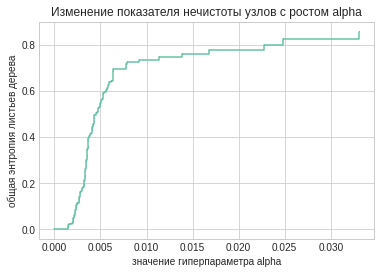

In [20]:
# изображаем на графике
plt.plot(ccp_alphas[:-1], impurities[:-1], marker=',', drawstyle="steps-post")
plt.xlabel("значение гиперпараметра alpha")
plt.ylabel("общая энтропия листьев дерева")
plt.title("Изменение показателя нечистоты узлов с ростом alpha")
plt.show()

In [21]:
# обучающая и тестовая выборки, чтобы сэкономить время
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=my_seed)

# модели
clfs = list()

# таймер
tic = time.perf_counter()
# цикл по значениям alpha
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=my_seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# таймер
toc = time.perf_counter()
print(f"Расчёты по обрезке дерева заняли {toc - tic:0.2f} секунд")

Расчёты по обрезке дерева заняли 0.76 секунд


In [22]:
# извлекаем характеристики глубины и точности
#  таймер
tic = time.perf_counter()
node_counts = [clf.tree_.node_count for clf in clfs]
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
#  таймер
toc = time.perf_counter()
print(f"Расчёты показателей точности заняли {toc - tic:0.2f} секунд")

Расчёты показателей точности заняли 0.21 секунд


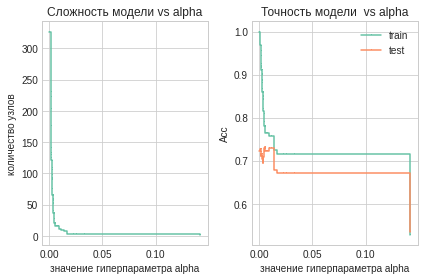

In [23]:
# изображаем на графике
fig, ax = plt.subplots(1, 2)

# график глубины дерева
ax[0].plot(ccp_alphas, node_counts, marker=',', drawstyle="steps-post")
ax[0].set_xlabel("значение гиперпараметра alpha")
ax[0].set_ylabel("количество узлов")
ax[0].set_title("Сложность модели vs alpha")

# график точности
ax[1].plot(ccp_alphas, train_scores, marker=',', label='train',
           drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores, marker=',', label='test',
           drawstyle="steps-post")
ax[1].set_xlabel("значение гиперпараметра alpha")
ax[1].set_ylabel("Acc")
ax[1].set_title("Точность модели  vs alpha")
ax[1].legend()
fig.tight_layout()

Находим оптимальный размер дерева по максимуму $Acc$ на тестовой выборке.  

In [24]:
# оптимальное количество узлов
opt_nodes_num = node_counts[test_scores.index(max(test_scores))]

# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=clfs[opt_nodes_num], X=X, y=y, cv=5,
                    scoring='accuracy')

# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('pruned_tree')

print('Оптимальное количество узлов:', opt_nodes_num,
      '\nсоответствующая Acc на тестовой:', np.around(max(test_scores), 3),
      '\n\nAcc с перекрёстной проверкой',
      '\nдля модели', score_models[1], ':', score[1])

Оптимальное количество узлов: 19 
соответствующая Acc на тестовой: 0.732 

Acc с перекрёстной проверкой 
для модели pruned_tree : 0.741


Посмотрим на характеристики глубины и сложности построенного дерева с обрезкой ветвей.

In [25]:
# выводим количество листьев (количество узлов)
clfs[opt_nodes_num].get_n_leaves()

67

In [26]:
# глубина дерева: количество узлов от корня до листа
#  в самой длинной ветви
clfs[opt_nodes_num].get_depth()

16

---

📚 **Пример визуализации небольшого дерева**

Лучшее дерево с обрезкой по-прежнему слишком велико для визуализации. Для примера нарисуем одно из небольших деревьев с обрезкой и выведем его же в виде текста.  

In [27]:
# находим деревья с количеством листьев меньше 20
[i for i in node_counts if i < 20]

[19,
 19,
 19,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 11,
 9,
 7,
 3,
 3,
 3,
 3,
 1]

Количество узлов: 11 
Точность дерева на тестовой: 0.729


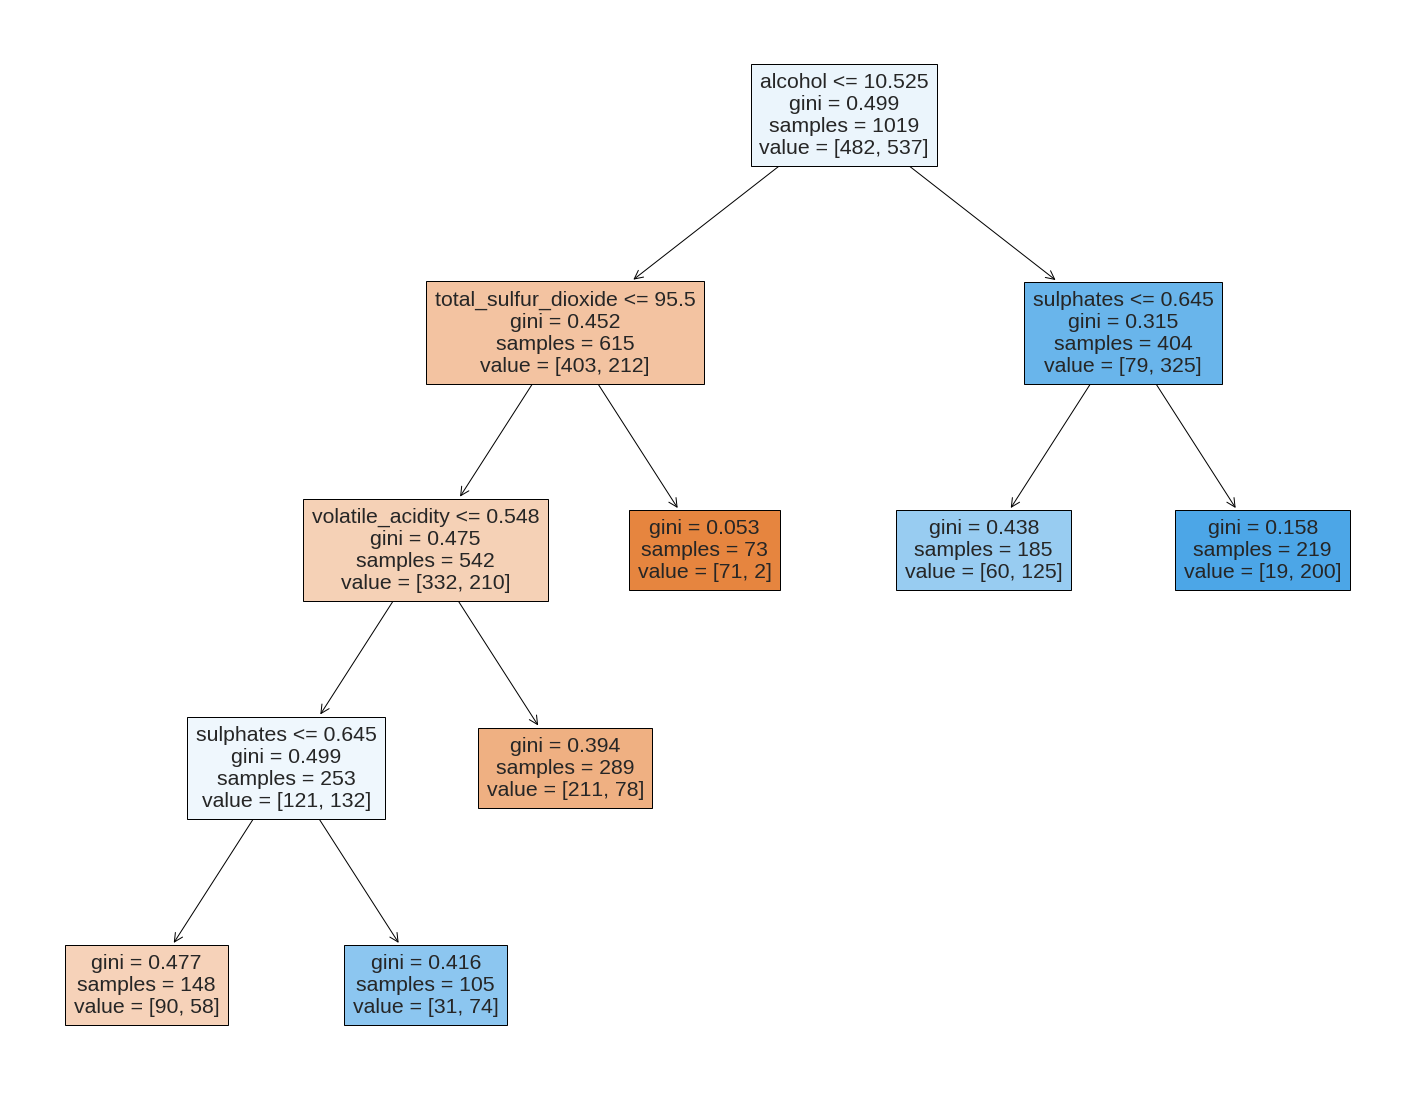

In [28]:
# визуализация на схеме НА ПРИМЕРЕ МАЛЕНЬКОГО ДЕРЕВА
nodes_num = 11
print('Количество узлов:', nodes_num,
      '\nТочность дерева на тестовой:', 
      np.around(test_scores[node_counts.index(nodes_num)], 3))

fig = plt.figure(figsize=(25,20))
_ = plot_tree(clfs[node_counts.index(nodes_num)], 
              filled=True, 
              feature_names=list(X.columns))

In [29]:
# визуализируем дерево в виде текстовой схемы
viz = export_text(clfs[node_counts.index(nodes_num)], 
                  feature_names=list(X.columns))
print(viz)

|--- alcohol <= 10.53
|   |--- total_sulfur_dioxide <= 95.50
|   |   |--- volatile_acidity <= 0.55
|   |   |   |--- sulphates <= 0.64
|   |   |   |   |--- class: 0
|   |   |   |--- sulphates >  0.64
|   |   |   |   |--- class: 1
|   |   |--- volatile_acidity >  0.55
|   |   |   |--- class: 0
|   |--- total_sulfur_dioxide >  95.50
|   |   |--- class: 0
|--- alcohol >  10.53
|   |--- sulphates <= 0.64
|   |   |--- class: 1
|   |--- sulphates >  0.64
|   |   |--- class: 1



# Бустинг 



Подберём сеточным поиском настроечные параметры модели:  
* $B$ число деревьев, 
* $\lambda$ – скорость обучения,
* $d$ – глубина взаимодействия предикторов.

In [30]:
num_trees = 50

# разбиения для перекрёстной проверки
kfold = KFold(n_splits=5, random_state=my_seed, shuffle=True)

# обучаем модель с параметрами по умолчанию
clf_tst = GradientBoostingClassifier(n_estimators=100, learning_rate=1,
                                    max_depth=1, random_state=my_seed)
cv = cross_val_score(clf_tst, X, y, cv=kfold, scoring='accuracy')
np.around(np.mean(cv), 3)

0.753

In [31]:
# настроим параметры бустинга с помощью сеточного поиска
param_grid = {'n_estimators' : [10, 20, 30, 40, 50],
            'learning_rate' : np.linspace(start=0.01, stop=0.25, num=15),
            'max_depth' : [1, 2]}

# таймер
tic = time.perf_counter()
clf = GridSearchCV(GradientBoostingClassifier(),
                   param_grid, scoring='accuracy', cv=kfold)
boost_tree = clf.fit(X, y)
# таймер
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')

Сеточный поиск занял 30.48 секунд


In [32]:
# точность лучшей модели
np.around(boost_tree.best_score_, 3)

0.77

In [33]:
# параметры лучшей модели
print('Оптимальные значения параметров:')
print('n_estimators:', 
      boost_tree.best_estimator_.get_params()['n_estimators'],
      '\nlearning_rate:',
      boost_tree.best_estimator_.get_params()['learning_rate'],
      '\nmax_depth:',
      boost_tree.best_estimator_.get_params()['max_depth'])

Оптимальные значения параметров:
n_estimators: 50 
learning_rate: 0.23285714285714287 
max_depth: 2


In [34]:
# записываем точность
score.append(np.around(boost_tree.best_score_, 3))
score_models.append('boost_tree_GS')

print('Acc с перекрёстной проверкой',
      '\nдля модели', score_models[2], ':', score[2])

Acc с перекрёстной проверкой 
для модели boost_tree_GS : 0.77



# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.  

In [35]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,one_tree,0.751
1,pruned_tree,0.741
2,boost_tree_GS,0.770


Все модели показывают среднюю точность по показателю $Acc$, при этом самой точной оказывается модель бустинга. Сделаем прогноз на отложенные наблюдения.   

In [36]:
# данные для прогноза
X_pred = DF_predict.drop(['Y'], axis=1)
# строим прогноз
y_hat = boost_tree.best_estimator_.predict(X_pred)
# характеристики точности
print(classification_report(DF_predict['Y'], y_hat))

              precision    recall  f1-score   support

           0       0.68      0.76      0.72       104
           1       0.80      0.73      0.76       136

    accuracy                           0.74       240
   macro avg       0.74      0.74      0.74       240
weighted avg       0.75      0.74      0.74       240



Сравним точность на отложенных наблюдениях с точностью моделей из упражнения 4.
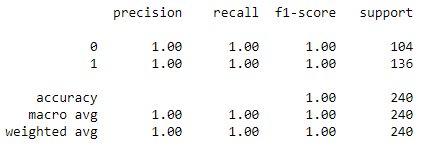

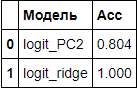

Точность моделей из упражнения 4 оказалась лучше.

# Источники 

1. Джеймс Г., Уиттон Д., Хасти Т., Тибширани Р. Введение в статистическое обучение с примерами на языке R. Пер. с англ. С.Э. Мастицкого – М.: ДМК Пресс, 2016 – 450 с.  
1. *Рашка С.* Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.  
1. *Tong Wang*, *Cynthia Rudin*, *Finale Doshi-Velez*, *Yimin Liu*, *Erica Klampfl*, *Perry MacNeille* A Bayesian Framework for Learning Rule Sets for Interpretable Classification / Journal of Machine Learning Research 18 (2017) 1-37. URL: <https://jmlr.org/papers/volume18/16-003/16-003.pdf>  
1. *George Pipis* How to Run the Chi-Square Test in Python / medium.com. URL: <https://medium.com/swlh/how-to-run-chi-square-test-in-python-4e9f5d10249d>   
1. *Bernd Klein* What are Decision Trees? / python-course.eu. URL: <https://www.python-course.eu/Decision_Trees.php>  
1. Pruning decision trees - tutorial / kaggle.com. URL: <https://www.kaggle.com/arunmohan003/pruning-decision-trees-tutorial>  
1. Post pruning decision trees with cost complexity pruning / scikit-learn.org. URL: <https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html>  
1. *Piotr Płoński* Visualize a Decision Tree in 4 Ways with Scikit-Learn and Python / mljar.com. URL: <https://mljar.com/blog/visualize-decision-tree/>  
1. Random Forest Feature Importance Plot / www.analyseup.com. URL: <https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html>  